This is for the old version of fastai. To adopt this script for new fastai, please refer to [this tutorial](https://sadiva-madaan9.medium.com/a-beginners-guide-to-fastai-s-image-dataloaders-1f698c6f09eb) and [documentation](https://docs.fast.ai/vision.data.html#imagedataloaders.from_df) of imagedataloaders. Please note that the data should be loaded differently.

**Do not directly run the code below**

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
from csv import reader
opened_file = open(r'/Soundclassification/ESC-50-master/meta/esc50.csv')
read_file = reader(opened_file)
metadata = list(read_file)

#### Based on the uran context, we don't want to classify every class of sounds in the dataset. So, just pick up these classes as follows.

In [ ]:
filter_list = ["airplane", "car_horn", "cat", "chirping_birds", "dog", "thunderstorm", "clapping", 
               "pouring_water", "train", "water_drops", "church_bells", "footsteps", "frog", "insects", 
               "laughing", "engine", "crying_baby", "coughing", "sneezing", "wind", "crickets"] 

In [ ]:
img_list = []
label_list = []
for row in metadata[1:]:
    if row[3] in filter_list:
        img_list += [row[0]]
        label_list += [row[3]]

In [ ]:
img_list[0],  label_list[0]

('1-100032-A-0.wav', 'dog')

In [ ]:
path = Path("/Soundclassification/croped_img/hyper")

In [ ]:
get_path = lambda x: f'{x.replace(".wav", "")}.jpg'

In [ ]:
img_path = []
for i in img_list:
    img_path += [get_path(i)]

In [ ]:
img_path[0]

'1-100032-A-0.jpg'

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({'img': img_path, 'label': label_list})
df.shape

(840, 2)

In [ ]:
(df["img"])[5], (df["label"])[5]

('1-104089-B-22.jpg', 'clapping')

In [ ]:
# set the size of pic
size = array([1110, 344])
size

array([1110,  344])

In [ ]:
# set the data for training
data = (ImageList.from_df(df, path) 
        .split_by_rand_pct(seed=1) # split the images randomly
        .label_from_df(cols='label') # get classes
        .transform(get_transforms(), size=size) # transform with the 'size = array([1110, 344])'
        .databunch(num_workers = 0)) # set databunch. 'num_workers' = 0 is necessary                          
data.normalize(imagenet_stats)

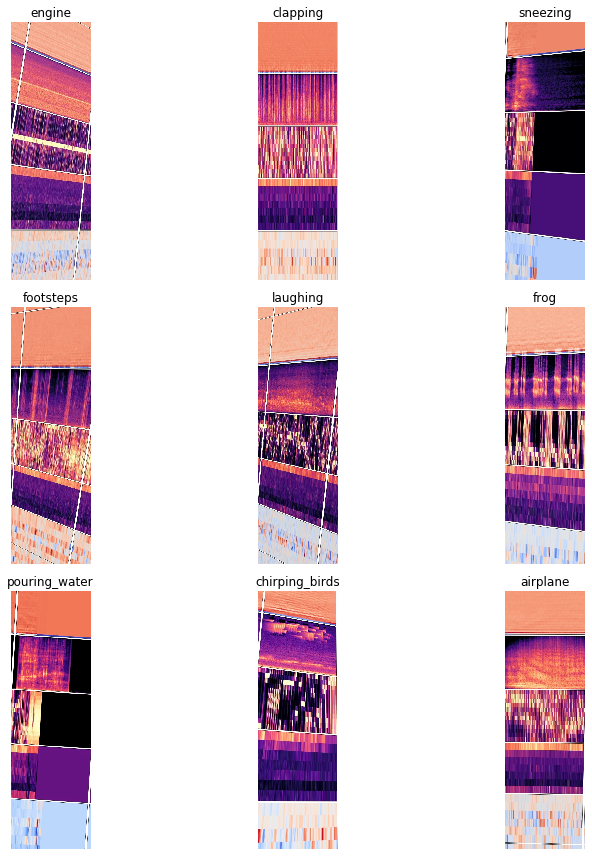

In [ ]:
# show the databunch
data.show_batch(rows=3)

In [ ]:
# bulid CNN model
learn = cnn_learner(data, models.resnet34, metrics = accuracy)

In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
# define the function for finding a good learning rate
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

In [ ]:
# find learning rate
find_appropriate_lr(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


0.006309573444801929

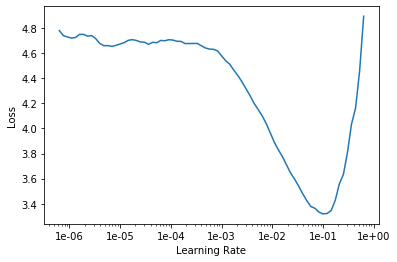

In [ ]:
# plot the learning rate
learn.recorder.plot()

In [ ]:
lr = 6.3e-3 # set a learn rate

In [ ]:
learn.fit_one_cycle(15, lr) # train model

epoch,train_loss,valid_loss,accuracy,time
0,4.512443,3.298404,0.113095,28:30
1,3.816186,2.080490,0.357143,28:52
2,3.115074,2.161388,0.440476,27:15
3,2.531431,1.821080,0.541667,30:09
4,2.080480,1.609768,0.607143,28:54
5,1.709934,1.514977,0.589286,28:49
6,1.423944,1.359687,0.613095,28:15
7,1.194224,1.384827,0.660714,25:53
8,1.012612,1.004491,0.726190,26:10
9,0.865144,0.990591,0.726190,26:32


In [ ]:
# unfreeze the model and train it again
learn.unfreeze()

In [ ]:
# find learning rate
find_appropriate_lr(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


0.00022908676527677726

In [ ]:
lr_2 = 2.3e-4
lrs = slice(lr_2/400,lr_2/4) # slice lr
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.204435,0.786576,0.803571,38:04
1,0.178569,0.789719,0.803571,39:26
2,0.172071,0.796221,0.803571,40:14
3,0.168907,0.787898,0.809524,39:55
4,0.170652,0.776288,0.809524,35:57
5,0.173505,0.770139,0.809524,33:21
6,0.164931,0.752754,0.803571,33:10
7,0.157576,0.751596,0.809524,33:37
8,0.144558,0.752899,0.803571,33:30
9,0.143897,0.741912,0.803571,33:32


#### In order to get higher accuracy, we should increas the number of epochs with keeping the learning rate..

In [ ]:
lr_3 = 2.3e-4
lrs = slice(lr_3/400,lr_3/4) # slice lr
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.129480,0.749451,0.803571,38:45
1,0.121811,0.746700,0.803571,39:34
2,0.128973,0.752728,0.803571,39:35
3,0.123137,0.757770,0.809524,41:09
4,0.121843,0.763464,0.809524,38:38
5,0.119903,0.759291,0.815476,39:40
6,0.121009,0.746148,0.809524,36:59
7,0.117822,0.747258,0.815476,40:59
8,0.112385,0.748340,0.815476,45:58
9,0.105527,0.752486,0.803571,46:43


In [ ]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.096665,0.750623,0.803571,44:36
1,0.112257,0.752926,0.815476,42:10
2,0.099399,0.753279,0.809524,38:29
3,0.098037,0.738297,0.803571,36:05
4,0.090914,0.739168,0.809524,31:51
5,0.091614,0.737092,0.809524,26:14
6,0.090959,0.721923,0.815476,25:40
7,0.091674,0.703926,0.815476,25:33
8,0.093269,0.703129,0.809524,25:45
9,0.085563,0.709880,0.809524,25:24


In [ ]:
learn.fit_one_cycle(20, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.065015,0.713552,0.809524,39:04
1,0.061480,0.715659,0.809524,39:34
2,0.053236,0.715739,0.809524,43:08
3,0.057376,0.713618,0.809524,42:07
4,0.058642,0.722175,0.809524,40:45
5,0.055611,0.726904,0.809524,38:49
6,0.058392,0.719644,0.815476,38:27
7,0.059184,0.713152,0.815476,41:03
8,0.057300,0.704629,0.815476,40:26
9,0.054000,0.704803,0.815476,36:54


In [ ]:
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.050637,0.707618,0.815476,36:52
1,0.045256,0.708691,0.815476,36:28
2,0.044521,0.709684,0.815476,32:36
3,0.045803,0.706076,0.815476,28:54
4,0.043923,0.709378,0.815476,35:52
5,0.042581,0.692300,0.821429,35:51
6,0.039768,0.691609,0.821429,34:10
7,0.042519,0.685067,0.815476,34:33
8,0.040048,0.683628,0.815476,35:46
9,0.040279,0.685184,0.815476,33:46


In [ ]:
learn.fit_one_cycle(5, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.037358,0.688115,0.821429,38:23
1,0.043379,0.686454,0.821429,38:41
2,0.045272,0.677128,0.833333,39:54
3,0.044203,0.686233,0.821429,38:19
4,0.043445,0.692011,0.833333,38:45


#### Finally, the accuracy reach 83.3%, which is comparable with some existing researches.

In [ ]:
learn.save('classification')

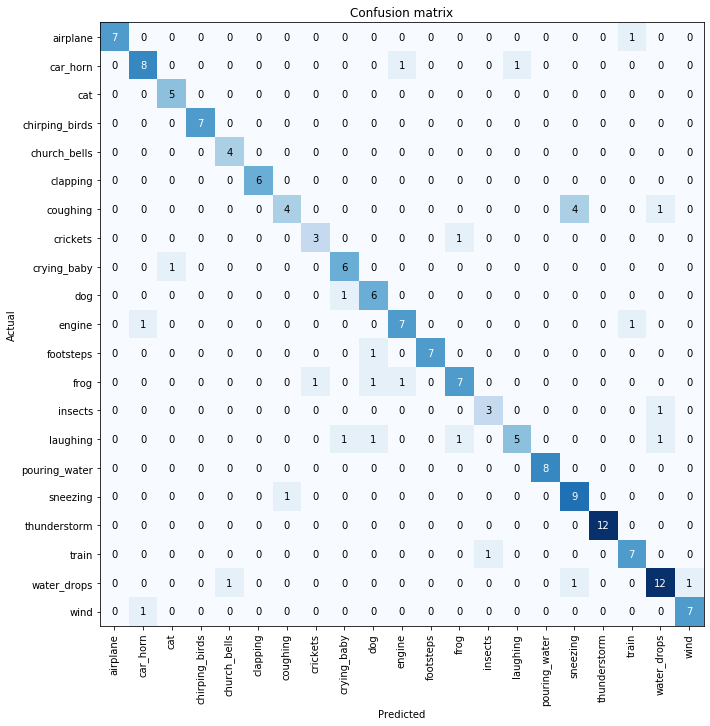

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='Confusion matrix', figsize=(10,10))